In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine, inspect

In [2]:
from secret import DESTINATION_DB_URL

In [3]:
# Check the tables that are available in destination_db
engine = create_engine(DESTINATION_DB_URL)
inspector = inspect(engine)
inspector.get_table_names()

['customers',
 'orders',
 'orderlines',
 'products',
 'stabcensus',
 'calendar',
 'campaigns']

In [4]:
# Test query and see if the data is loaded correctly, and see if the memory usage make sense
query = """
select * from orders
limit 5
"""
df = pd.read_sql(query, engine)
display(df)
df.info()

,orderid,numorderlines,numunits,paymenttype,totalprice,state,city,orderdate,campaignid
0,1002854,3,3,VI,$190.00,MA,NEWTON,2009-10-13,2141
1,1002855,1,1,VI,$10.00,NY,NEW ROCHELLE,2009-10-13,2173
2,1002856,2,2,AE,$35.22,FL,MIAMI,2011-06-02,2141
3,1002857,1,1,AE,$10.00,NJ,E RUTHERFORD,2009-10-14,2173
4,1002886,1,1,VI,$10.00,MD,BALTIMORE,2010-11-19,2141


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   orderid        5 non-null      int64 
 1   numorderlines  5 non-null      int64 
 2   numunits       5 non-null      int64 
 3   paymenttype    5 non-null      object
 4   totalprice     5 non-null      object
 5   state          5 non-null      object
 6   city           5 non-null      object
 7   orderdate      5 non-null      object
 8   campaignid     5 non-null      int64 
dtypes: int64(4), object(5)
memory usage: 488.0+ bytes


### EDA 

In [5]:
# see the unique value in calendar holidaytype
query = """
select 
    holidaytype,
    count(date) as count
from calendar
group by holidaytype
order by count desc;
"""
holiday_type = pd.read_sql(query, engine)
holiday_type

,holidaytype,count
0,,33207
1,minor,909
2,national,909
3,jewish,775
4,other,522
5,christian,293
6,muslim,187
7,chinese,88


In [6]:
# let's see what is the distribution of holiday and the campaign it used
query = """
select
    case when c.holidaytype = '' then 'N' else 'Y' end as isholiday,
    ca.discount,
    ca.freeshppingflag,
    count(o.orderid) as order_count
from orders o
left join calendar c on o.orderdate=c.date
left join campaigns ca on o.campaignid=ca.campaignid
group by 
    isholiday,
    ca.discount,
    ca.freeshppingflag;
"""
df_campaign_holiday = pd.read_sql(query, engine)
df_campaign_holiday

,isholiday,discount,freeshppingflag,order_count
0,N,0,N,100570
1,N,0,Y,902
2,N,10,N,69603
3,N,10,Y,557
4,N,15,N,140
5,N,20,N,161
6,N,20,Y,1049
7,N,25,N,167
8,N,30,N,406
9,N,32,N,16


In [7]:
# let's see if there any association between freeshipping/discount and holiday
contingency_table = pd.crosstab(df_campaign_holiday['isholiday'],df_campaign_holiday['freeshppingflag'], values=df_campaign_holiday['order_count'], aggfunc='sum')
display(contingency_table)
# Perform Chi-Square Test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

corr_coef = (df_campaign_holiday['isholiday']=='Y').corr(df_campaign_holiday['discount'])
print(f"Correlation coefficient: {corr_coef}")

freeshppingflag,N,Y
isholiday,,
N,171209,2508
Y,18649,617


Chi-Square Statistic: 335.64846751365565
P-value: 5.656850205642618e-75
Correlation coefficient: -0.0927392438793299


small p-value indicates that maybe there is a significant association between holiday and freeshipping, <br>
the correlation coefficient close to zero indicates that the relation between either it is holiday or not and the amount of discount is weak

In [8]:
df_campaign_holiday['isdiscount'] = df_campaign_holiday['discount'].apply(lambda x: 'Y' if x>0 else 'N')
display(df_campaign_holiday.sample(5))
contingency_table = pd.crosstab(df_campaign_holiday['isholiday'],df_campaign_holiday['isdiscount'], values=df_campaign_holiday['order_count'], aggfunc='sum')
display(contingency_table)
# Perform Chi-Square Test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

,isholiday,discount,freeshppingflag,order_count,isdiscount
18,Y,20,N,12,Y
17,Y,15,N,22,Y
4,N,15,N,140,Y
10,N,40,N,86,Y
20,Y,25,N,24,Y


isdiscount,N,Y
isholiday,,
N,101472,72245
Y,10917,8349


Chi-Square Statistic: 21.707190149489733
P-value: 3.175986494210284e-06


small p-value indicates that maybe there is a significant association between either it is holiday or not and if there is a discount or not.

In [9]:
pricef = lambda x: f"cast(translate({x},\'$,\',\'\') as decimal(10,2))"
query = """
select paymenttype, count(orderid) as order_count, sum({}) as revenue
from orders
group by paymenttype;
""".format(pricef('totalprice'))
df_paymenttype = pd.read_sql(query, engine)
df_paymenttype

,paymenttype,order_count,revenue
0,??,313,1184.17
1,AE,47382,4656038.04
2,DB,12739,471008.74
3,MC,47318,3302579.39
4,OC,8214,264647.83
5,VI,77017,5013438.13


In [10]:
dict_paymenttype = {
    "AE" : "American Express",
    "DB" : "Debit",
    "MC" : "Master Card",
    "OC" : "Online Check",
    "VI" : "Visa",
    "??" : "Other"
}

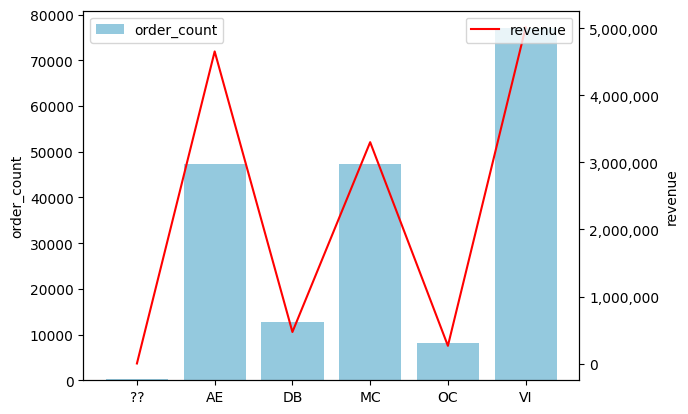

In [11]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
x = np.arange(df_paymenttype.shape[0])
sns.barplot(x=x, y='order_count', data=df_paymenttype, ax=ax, color='skyblue', label='order_count')
ax1 = ax.twinx()
ax1.plot(x, df_paymenttype['revenue'], color='red', label='revenue')
ax1.set_xticks(x)
ax1.set_xticklabels(df_paymenttype['paymenttype'])
ax1.set_xlabel('paymenttype')
ax1.set_ylabel('revenue')

formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
ax1.yaxis.set_major_formatter(formatter)

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
plt.show()

In [12]:
corr_coef = df_paymenttype['order_count'].corr(df_paymenttype['revenue'])
print(f"Correlation coefficient : {corr_coef}")

Correlation coefficient : 0.9595135070407164


Since the correlation coefficient is close to one, then there is a strong positive relation between the order_count and the revenue of each paymenttype.

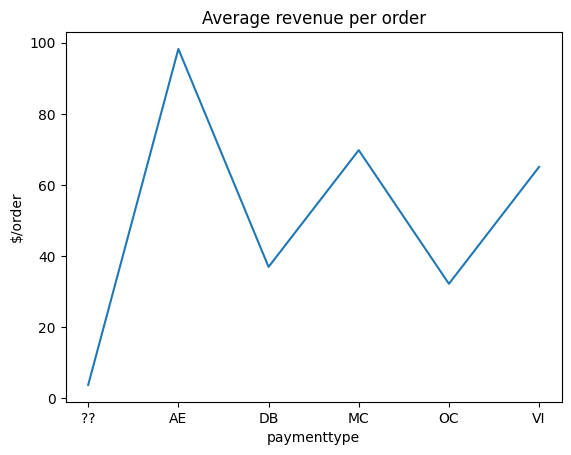

In [13]:
df_paymenttype['avg_revenue_per_order']=df_paymenttype['revenue']/df_paymenttype['order_count']
fig, ax = plt.subplots()

ax.plot(df_paymenttype['paymenttype'], df_paymenttype['avg_revenue_per_order'])
ax.set_title('Average revenue per order')
ax.set_xlabel('paymenttype')
ax.set_ylabel('$/order')

plt.show()

On average, AE users spent the most, even though Visa had the highest total revenue

In [14]:
from datetime import datetime
months = [datetime(2024,i,1).strftime('%b') for i in range(1,13)]
", ".join(months)

'Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec'

In [16]:
order_months = map(lambda x: f"sum(case when to_char(orderdate, \'Mon\')=\'{x}\' then 1 else 0 end) as {x}", months)
query = """
select paymenttype, {}
from orders
group by paymenttype;
""".format(", ".join(order_months))
df_payment_orders = pd.read_sql(query, engine)
display(df_payment_orders)

,paymenttype,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,??,59,6,120,12,7,13,9,5,8,8,28,38
1,AE,4773,2623,3126,2775,3232,3711,2733,2766,3010,3337,6832,8464
2,DB,1716,821,647,555,503,641,639,692,724,1146,2494,2161
3,MC,4440,2756,3046,2712,3201,4079,2733,2775,3094,3233,6607,8642
4,OC,431,291,427,484,325,495,364,2392,509,928,648,920
5,VI,7761,4427,4804,4341,5163,6136,4532,4691,4984,5514,10703,13961


In general, the highest number of orders occurs in December, with an anomaly for OC users, where peak orders happen in August.

In [17]:
revenue_months = map(lambda x: f"sum(case when to_char(orderdate, \'Mon\')=\'{x}\' then {pricef('totalprice')} else 0 end) as {x}", months)
query = """
select paymenttype, {}
from orders
group by paymenttype;
""".format(", ".join(revenue_months))
df_payment_revenues = pd.read_sql(query, engine)
display(df_payment_revenues)

,paymenttype,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,??,23.40,367.30,496.59,101.79,35.00,0.00,0.00,0.00,0.00,0.00,0.00,160.09
1,AE,378077.15,257871.17,361023.46,302804.83,352306.08,362399.48,337711.55,305801.55,259902.15,285461.90,625905.31,826773.41
2,DB,51953.65,26472.22,38741.05,32144.61,32627.74,32458.77,41077.36,30783.21,20366.85,39501.97,78027.96,46853.35
3,MC,244118.74,193651.20,234306.58,203646.96,264154.60,254177.46,241339.74,208598.85,194668.75,198563.57,440608.81,624744.13
4,OC,23745.54,14908.64,14156.09,15188.86,19067.05,26209.84,16381.46,12708.95,18691.11,14643.86,37568.19,51378.24
5,VI,396105.76,281292.77,346766.40,312283.95,372495.78,418100.45,342232.66,305119.41,286479.93,344104.87,694762.89,913693.26


In [20]:
df_payment_avg = df_payment_revenues.copy()
df_payment_avg.iloc[:, 1:] /= df_payment_orders.iloc[:, 1:]
display(df_payment_avg)

,paymenttype,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,??,0.396610,61.216667,4.138250,8.482500,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.212895
1,AE,79.211638,98.311540,115.490550,109.118858,109.005594,97.655478,123.568075,110.557321,86.346229,85.544471,91.613775,97.681168
2,DB,30.276020,32.243873,59.877975,57.918216,64.866282,50.637707,64.283818,44.484408,28.131008,34.469433,31.286271,21.681328
3,MC,54.981698,70.265312,76.922712,75.091062,82.522524,62.313670,88.305796,75.170757,62.918148,61.417745,66.688181,72.291614
4,OC,55.094060,51.232440,33.152436,31.381942,58.667846,52.949172,45.004011,5.313106,36.721238,15.780022,57.975602,55.845913
5,VI,51.037980,63.540269,72.182848,71.938252,72.147159,68.138926,75.514709,65.043575,57.479922,62.405671,64.912911,65.446118


We can see that AE users has the most spending on average throughout the year.